### POD 91 resources usage prediction with Meta Prophet library

## Load the CPU dataset

First, we need to load the dataset and change the DataFrame columns from **Timestamp** and **cpu_utilization** into **ds** and **y**, which are the column names expected by Prophet.

In [1]:
import pandas as pd

# Load the dataset
file_path = 'MS_68185_POD_91_CPU.csv'
data = pd.read_csv(file_path, parse_dates=True)

# Convert the timestamp to the desired format
# Start date is 01/01/2022
start_date = pd.Timestamp('2022-01-01')

# Convert the timestamp from milliseconds to seconds and add it to the start date
data['timestamp'] = data['timestamp'].apply(lambda x: start_date + pd.Timedelta(seconds=x/1000))

# Columns renamed to ds and y, making it ready for use with Prophet for time series forecasting.
new_data = data.rename(columns={'timestamp': 'ds', 'cpu_utilization': 'y'})


# Display the first few rows of t, parse_dates=Truehe dataset
new_data.head()

,ds,y
0,2022-01-01 00:00:00,0.190373
1,2022-01-01 00:01:00,0.183195
2,2022-01-01 00:02:00,0.173558
3,2022-01-01 00:03:00,0.168516
4,2022-01-01 00:04:00,0.170707


## Fit the CPU Prophet model
We utilize the Prophet library to fit the model and estimate the duration.

In [2]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import time


# Initialize and fit the Prophet model
model = Prophet()

# Record start time
start_time = time.time()

model.fit(new_data)

# Record end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time



print(f"Prophet model fitting took {processing_time} seconds.")




Importing plotly failed. Interactive plots will not work.
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitting took 9.728728294372559 seconds.


## CPU data forecast Cross validation

The cross-validation approach is a technique that involves using historical data to simulate a forecast and comparing the predicted values against the actual values. This technique is useful in evaluating the performance of a model realistically and can help you compare or fine-tune different models. 

To generate predictions using the cross-validation method, we use the Prophet "cross_validation" function, which fits the model on a rolling window basis. 

The following parameters are used in this process: 

- Horizon: This is the forecast horizon for which you want to compute the performance metrics. 

- Initial: This refers to the size of the initial training period. 

- Period: This specifies the spacing between cutoff dates for the rolling window. 

By using this technique, we can evaluate your model's performance accurately and make better decisions based on the results.

In [3]:
# Perform cross-validation
# 'horizon' is the forecast horizon, 'period' specifies the spacing between cutoff dates,
# and 'initial' is the size of the initial training period
df_cv = cross_validation(model, horizon='6 days', period='3 days', initial='14 days')


  0%|          | 0/1 [00:00<?, ?it/s]

14:31:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:03 - cmdstanpy - INFO - Chain [1] done processing


## Plot the actual vs predicted CPU values

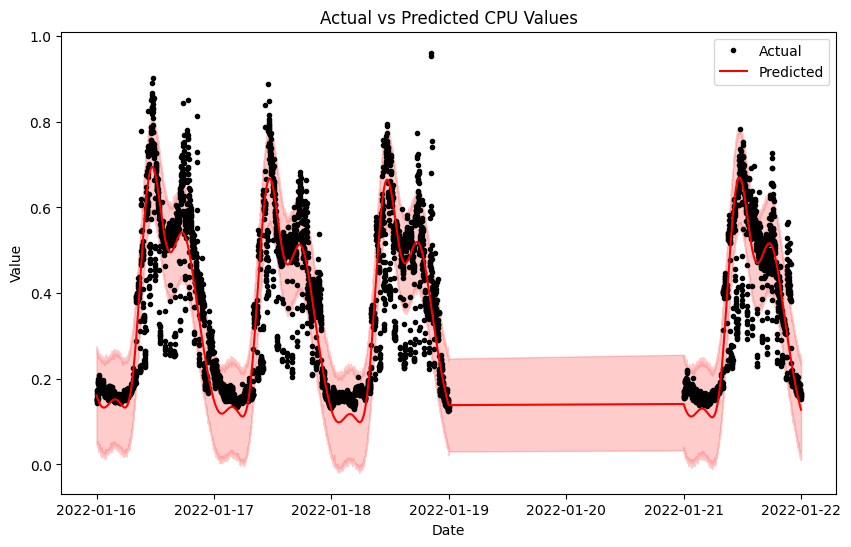

In [4]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], 'k.', label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], 'r-', label='Predicted')
plt.fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted CPU Values')
plt.show()


## CPU Forecast Performance Metrics

In [5]:
df_p = performance_metrics(df_cv)
df_p.head()




,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 09:35:00,0.002250,0.047436,0.031086,0.147907,0.133036,0.150300,0.968696
1,0 days 09:36:00,0.002317,0.048135,0.031408,0.148786,0.133160,0.150953,0.966957
2,0 days 09:37:00,0.002389,0.048882,0.031753,0.149781,0.133200,0.151702,0.965217
3,0 days 09:38:00,0.002457,0.049564,0.032085,0.150700,0.134058,0.152406,0.963478
4,0 days 09:39:00,0.002528,0.050281,0.032428,0.151662,0.134065,0.153135,0.961739


## Calculate MAE, MSE, and RMSE for CPU forecast

In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 0.06
Mean Squared Error: 0.01
Root Mean Squared Error: 0.09


## Plot the MAE metric from the CPU cross-validation

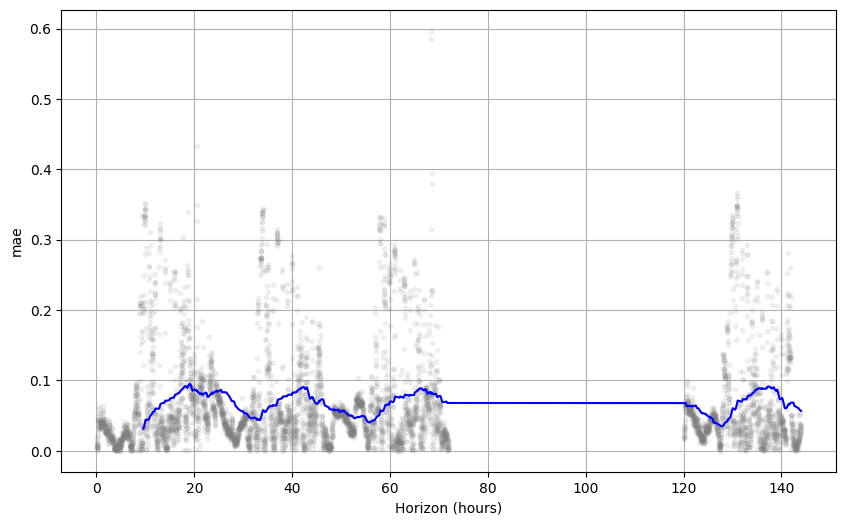

In [7]:
# Plot the MAE metric from the cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mae')

# Display the plot
plt.show()

## 4 days CPU Forecast

In [8]:
# Record start time
start_time = time.time()

# generating a DataFrame containing future dates for which predictions are to be made
future = model.make_future_dataframe(periods=5760, freq='1min')

# 4 days forecast expressed in minutes
forecast = model.predict(future)

# Record end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

print(f"Prophet four days future prediction fitting took {processing_time} seconds.")

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

Prophet four days future prediction fitting took 6.220564126968384 seconds.


,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01 00:00:00,0.188955,0.078018,0.302571
1,2022-01-01 00:01:00,0.188353,0.076610,0.305932
2,2022-01-01 00:02:00,0.187756,0.074953,0.297320
3,2022-01-01 00:03:00,0.187165,0.074749,0.295746
4,2022-01-01 00:04:00,0.186580,0.063078,0.304739
...,...,...,...,...
33093,2022-01-25 23:55:00,0.118251,-0.001616,0.231449
33094,2022-01-25 23:56:00,0.117630,0.006618,0.225239
33095,2022-01-25 23:57:00,0.117014,0.006402,0.235321
33096,2022-01-25 23:58:00,0.116404,0.007836,0.225265


## CPU 4 days Forecast Plot

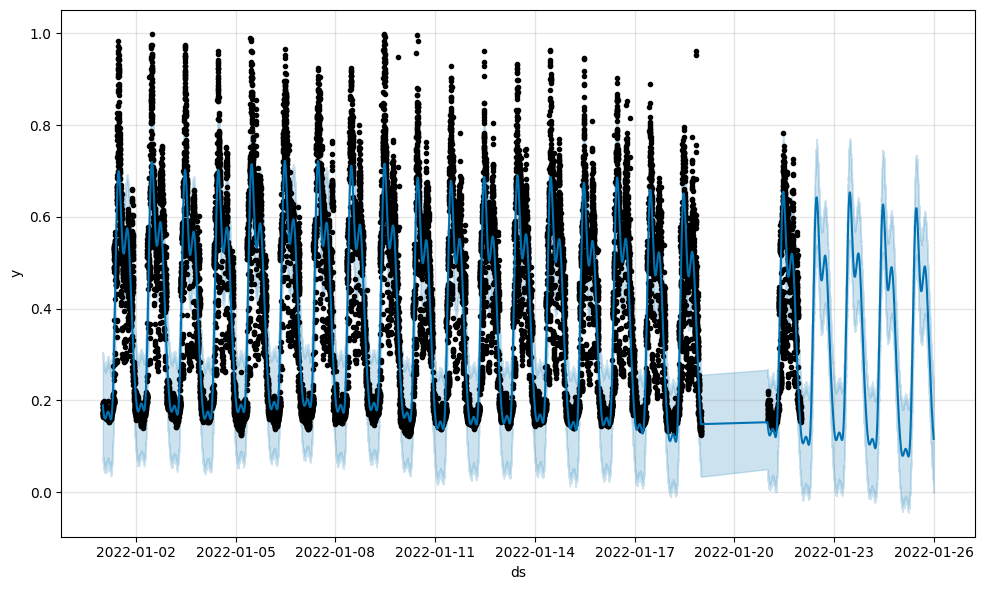

In [9]:
fig1 = model.plot(forecast)



## CPU 4 days Forecast Components Plot

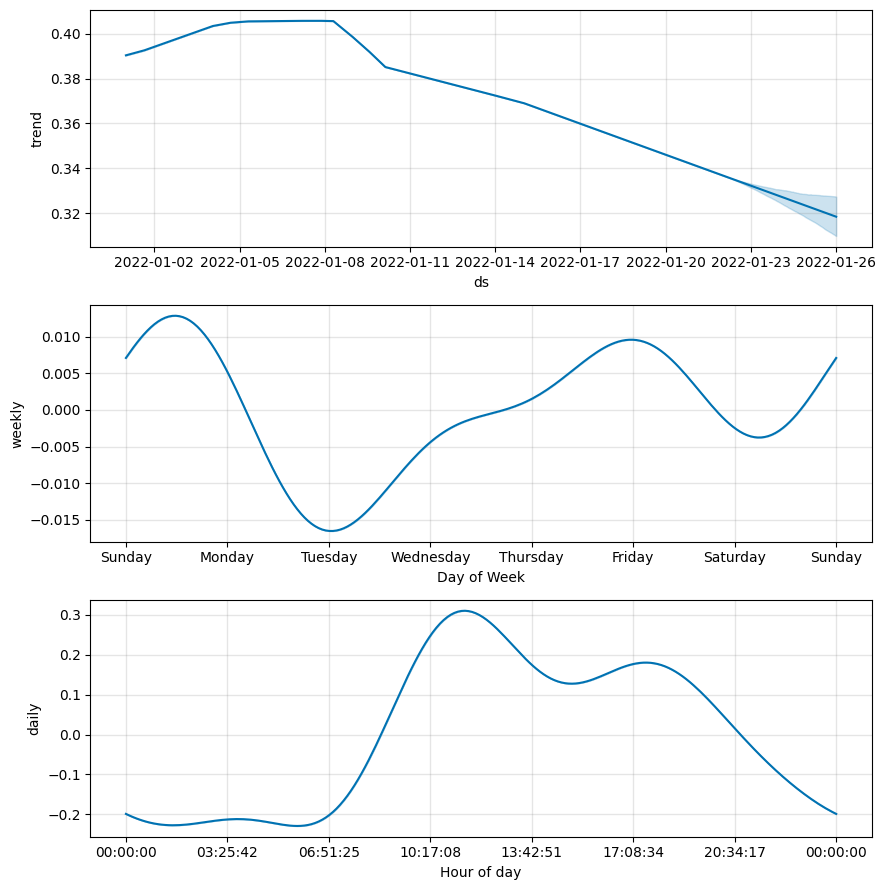

In [10]:

fig2 = model.plot_components(forecast)

## 30 days CPU Forecast

In [11]:
# Record start time
start_time = time.time()

# generating a DataFrame containing future dates for which predictions are to be made
future = model.make_future_dataframe(periods=43200, freq='1min')
# 30 days forecast expressed in minutes
forecast = model.predict(future)

# Record end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

print(f"Prophet 30 days future prediction fitting took {processing_time} seconds.")

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

Prophet 30 days future prediction fitting took 25.037322998046875 seconds.


,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01 00:00:00,0.188955,0.078810,0.297835
1,2022-01-01 00:01:00,0.188353,0.081223,0.296460
2,2022-01-01 00:02:00,0.187756,0.084189,0.299922
3,2022-01-01 00:03:00,0.187165,0.074224,0.297330
4,2022-01-01 00:04:00,0.186580,0.073335,0.292448
...,...,...,...,...
70533,2022-02-20 23:55:00,0.008452,-0.219482,0.233424
70534,2022-02-20 23:56:00,0.007804,-0.210383,0.238114
70535,2022-02-20 23:57:00,0.007161,-0.212842,0.231253
70536,2022-02-20 23:58:00,0.006524,-0.208980,0.230809


## CPU 30 days Forecast Plot

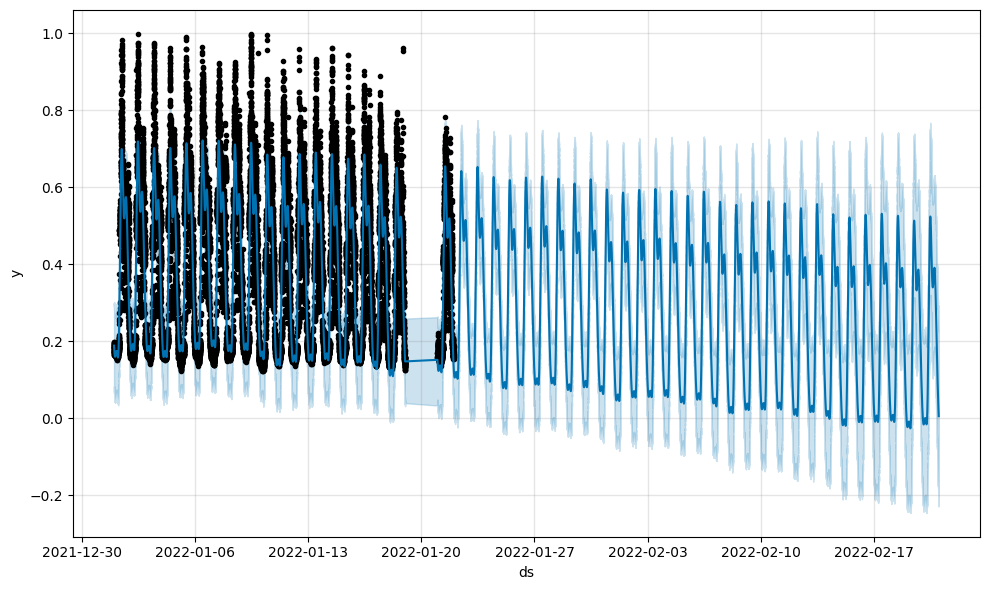

In [12]:
fig1 = model.plot(forecast)

## CPU 30 days Forecast Components Plot

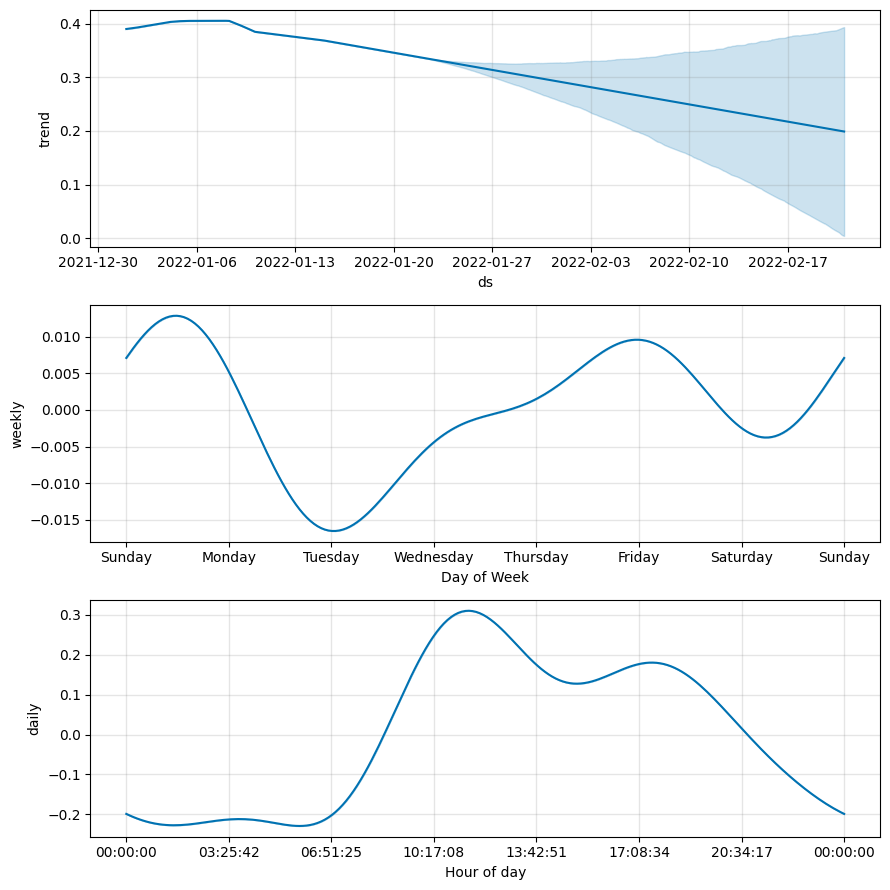

In [13]:
fig2 = model.plot_components(forecast)

## Load the Memory dataset

In [14]:
import pandas as pd

# Load the dataset
file_path = 'MS_68185_POD_91_Memory.csv'
memory_data = pd.read_csv(file_path, parse_dates=True)

# Convert the timestamp to the desired format
# Start date is 01/01/2022
start_date = pd.Timestamp('2022-01-01')

# Convert the timestamp from milliseconds to seconds and add it to the start date
memory_data['timestamp'] = memory_data['timestamp'].apply(lambda x: start_date + pd.Timedelta(seconds=x/1000))

# Columns renamed to ds and y, making it ready for use with Prophet for time series forecasting.
new_memory_data = memory_data.rename(columns={'timestamp': 'ds', 'memory_utilization': 'y'})


# Display the first few rows of t, parse_dates=Truehe dataset
new_memory_data.head()

,ds,y
0,2022-01-01 00:00:00,0.662515
1,2022-01-01 00:01:00,0.662292
2,2022-01-01 00:02:00,0.662423
3,2022-01-01 00:03:00,0.662563
4,2022-01-01 00:04:00,0.662420


## Fit the Memory Prophet model

In [15]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import time


# Initialize and fit the Prophet model
model = Prophet()

# Record start time
start_time = time.time()

model.fit(new_memory_data)

# Record end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time



print(f"Prophet model fitting took {processing_time} seconds.")




14:32:51 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitting took 29.134223222732544 seconds.


## Memory data forecast Cross validation

In [16]:
# Perform cross-validation
# 'horizon' is the forecast horizon, 'period' specifies the spacing between cutoff dates,
# and 'initial' is the size of the initial training period
df_memory_cv = cross_validation(model, horizon='6 days', period='3 days', initial='14 days')


  0%|          | 0/1 [00:00<?, ?it/s]

14:33:20 - cmdstanpy - INFO - Chain [1] start processing
14:33:40 - cmdstanpy - INFO - Chain [1] done processing


## Plot the actual vs predicted Memory values

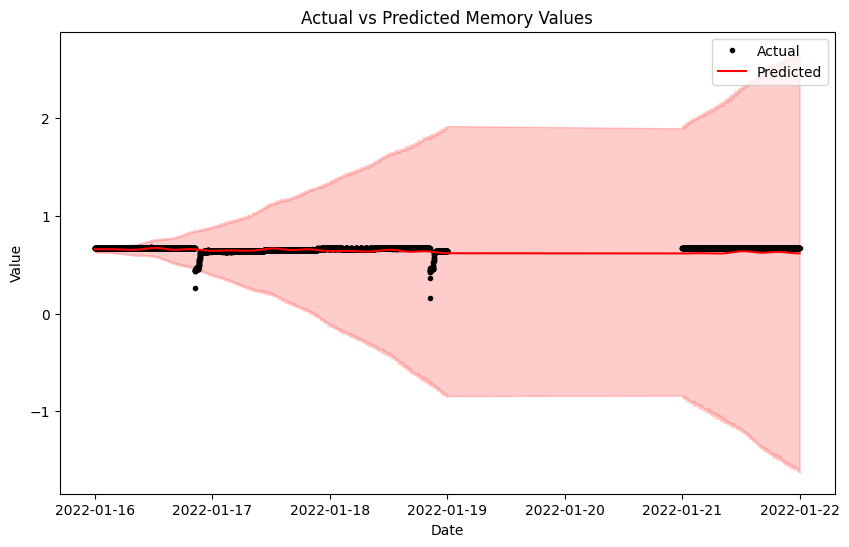

In [17]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_memory_cv ['ds'], df_memory_cv ['y'], 'k.', label='Actual')
plt.plot(df_memory_cv ['ds'], df_memory_cv ['yhat'], 'r-', label='Predicted')
plt.fill_between(df_memory_cv['ds'], df_memory_cv ['yhat_lower'], df_memory_cv['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Memory Values')
plt.show()


## Memory Forecast Performance Metrics

In [18]:
df_memory_p = performance_metrics(df_memory_cv)
df_memory_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 09:35:00,0.000232,0.015247,0.015023,0.022351,0.021558,0.022612,1.0
1,0 days 09:36:00,0.000232,0.015247,0.015023,0.022352,0.021558,0.022612,1.0
2,0 days 09:37:00,0.000232,0.015248,0.015024,0.022353,0.021558,0.022613,1.0
3,0 days 09:38:00,0.000233,0.015249,0.015026,0.022355,0.021558,0.022616,1.0
4,0 days 09:39:00,0.000233,0.015251,0.015028,0.022358,0.021558,0.022619,1.0


## Calculate MAE, MSE, and RMSE for Memory forecast

In [19]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_memory_cv['y'], df_memory_cv['yhat'])
mse = mean_squared_error(df_memory_cv['y'], df_memory_cv['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 0.03
Mean Squared Error: 0.00
Root Mean Squared Error: 0.04


## Plot the MAE metric from the Memory cross-validation

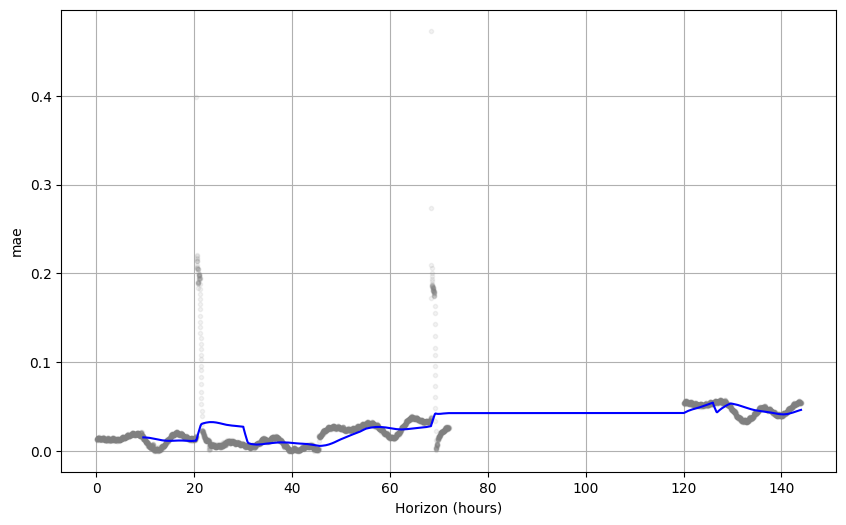

In [20]:
# Plot the MAE metric from the cross-validation
fig = plot_cross_validation_metric(df_memory_cv, metric='mae')

# Display the plot
plt.show()

## 4 days Memory Forecast

In [21]:
# Record start time
start_time = time.time()

# generating a DataFrame containing future dates for which predictions are to be made
future_memory = model.make_future_dataframe(periods=5760, freq='1min')

# 4 days forecast expressed in minutes
forecast_memory = model.predict(future_memory)

# Record end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

print(f"Prophet four days future prediction fitting took {processing_time} seconds.")

forecast_memory[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

Prophet four days future prediction fitting took 6.165812015533447 seconds.


,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01 00:00:00,0.658144,0.622426,0.689736
1,2022-01-01 00:01:00,0.658171,0.625823,0.691858
2,2022-01-01 00:02:00,0.658199,0.623599,0.690691
3,2022-01-01 00:03:00,0.658226,0.624028,0.691137
4,2022-01-01 00:04:00,0.658253,0.622952,0.691687
...,...,...,...,...
33093,2022-01-25 23:55:00,0.640391,-0.175764,1.464607
33094,2022-01-25 23:56:00,0.640402,-0.176197,1.466378
33095,2022-01-25 23:57:00,0.640412,-0.169943,1.455284
33096,2022-01-25 23:58:00,0.640423,-0.172523,1.473116


## Memory 4 days Forecast Plot

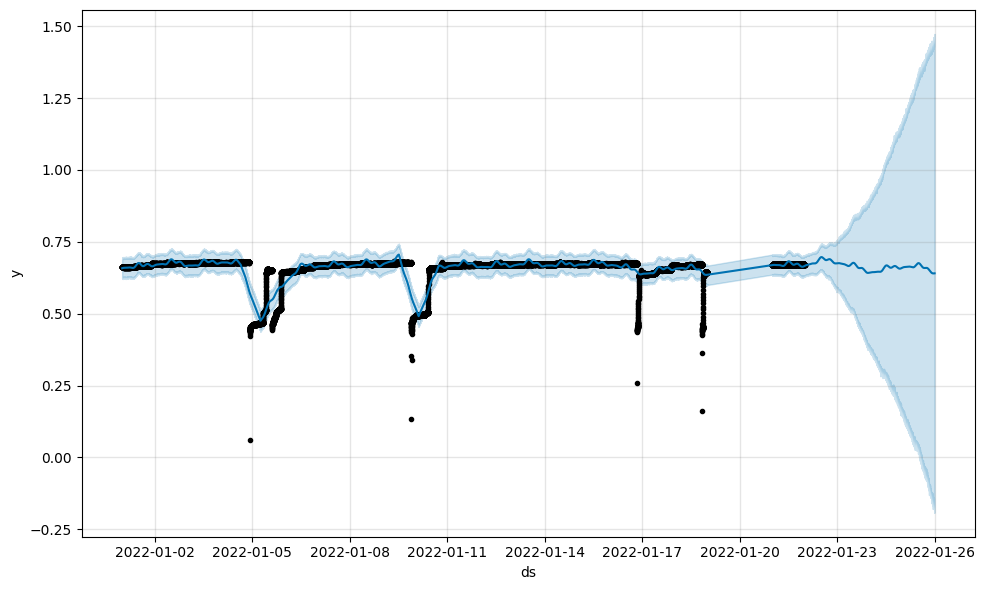

In [22]:
fig1 = model.plot(forecast_memory)


## Memory 4 days Forecast Components Plot

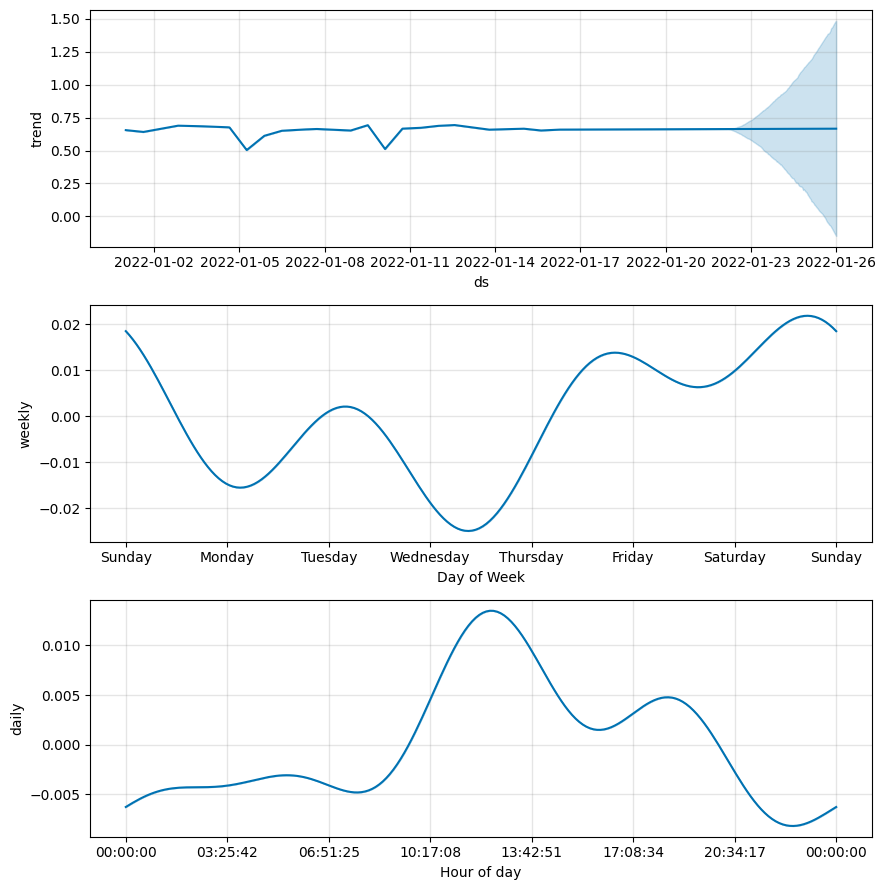

In [23]:
fig2 = model.plot_components(forecast_memory)

## 30 days Memory Forecast

In [24]:
# Record start time
start_time = time.time()

# generating a DataFrame containing future dates for which predictions are to be made
future_memory = model.make_future_dataframe(periods=43200, freq='1min')
# 30 days forecast expressed in minutes
forecast_memory = model.predict(future_memory)

# Record end time
end_time = time.time()

# Calculate processing time
processing_time = end_time - start_time

print(f"Prophet 30 days future prediction fitting took {processing_time} seconds.")

forecast_memory[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

Prophet 30 days future prediction fitting took 24.2752902507782 seconds.


,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01 00:00:00,0.658144,0.625455,0.694547
1,2022-01-01 00:01:00,0.658171,0.625240,0.692802
2,2022-01-01 00:02:00,0.658199,0.627322,0.693711
3,2022-01-01 00:03:00,0.658226,0.623114,0.691943
4,2022-01-01 00:04:00,0.658253,0.623549,0.693213
...,...,...,...,...
70533,2022-02-20 23:55:00,0.663114,-16.877471,19.608693
70534,2022-02-20 23:56:00,0.663138,-16.924210,19.609347
70535,2022-02-20 23:57:00,0.663161,-16.877125,19.621940
70536,2022-02-20 23:58:00,0.663184,-16.849000,19.627350


## Memory 30 days Forecast Components Plot

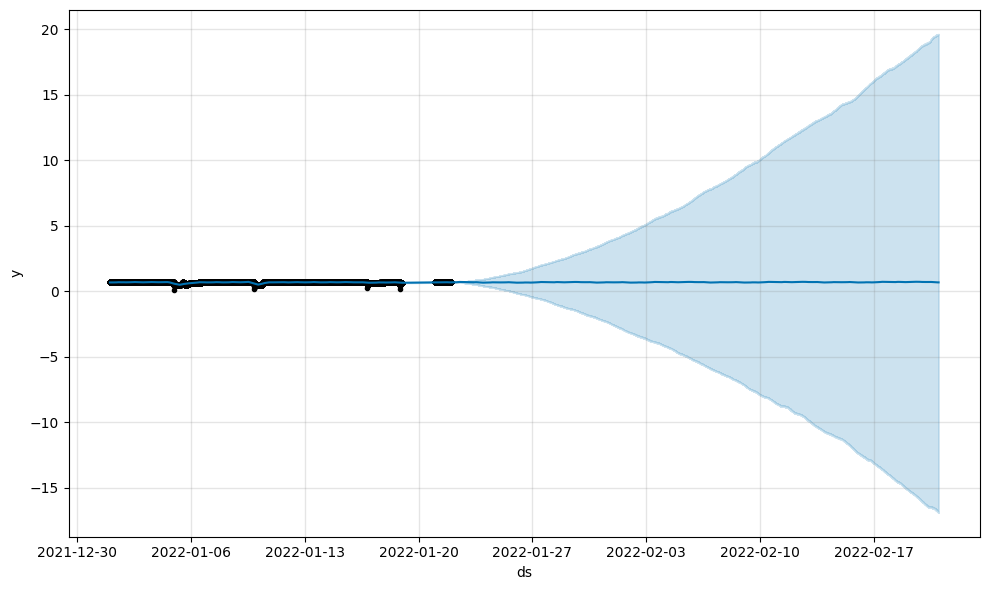

In [25]:
fig1 = model.plot(forecast_memory)

## Memory 30 days Forecast Components Plot

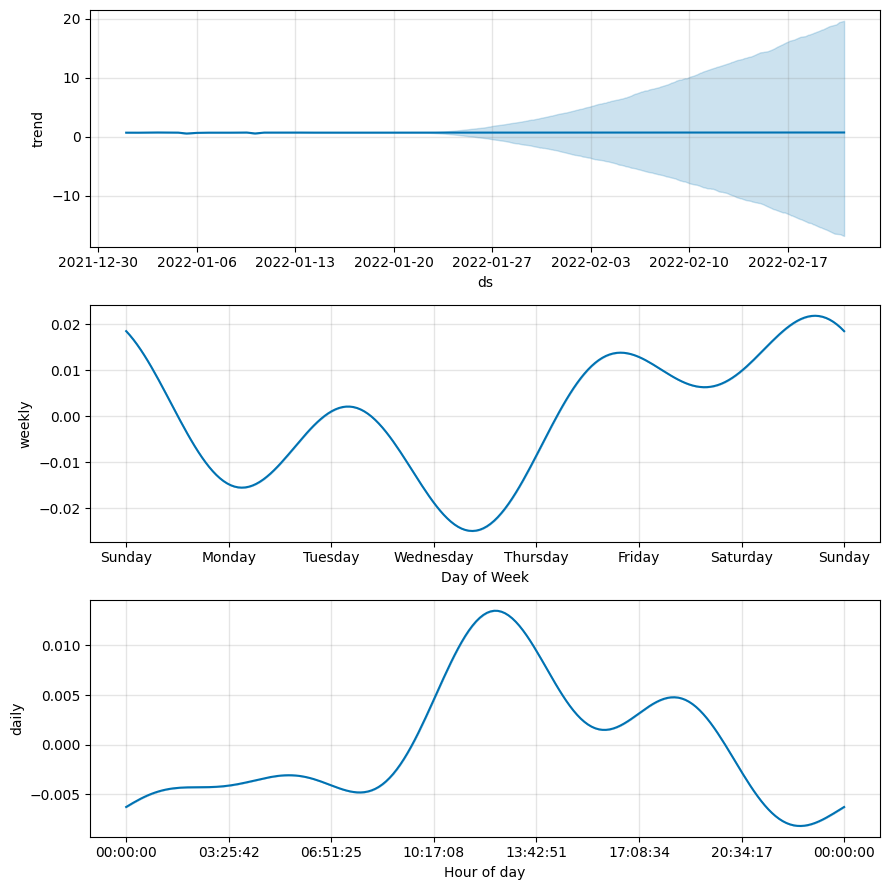

In [26]:
fig2 = model.plot_components(forecast_memory)